In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

import unicodedata
import re
import numpy as np
import os
import io
import time
import tensorflow_text as tf_text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
europarl_lines = pd.read_csv('/kaggle/input/nmt-capstone/europarl-v7.csv')
europarl_lines_bp = europarl_lines.copy()
europarl_lines = europarl_lines[:25000]
europarl_lines.reset_index(drop=True, inplace=True)
europarl_lines.head()

,index,German_Text,English_Text,all_text
0,0,Wiederaufnahme der Sitzungsperiode,Resumption of the session,Resumption of the session;Wiederaufnahme der S...
1,1,"Ich erkläre die am Freitag, dem 17. Dezember u...",I declare resumed the session of the European ...,I declare resumed the session of the European ...
2,2,"Wie Sie feststellen konnten, ist der gefürchte...","Although, as you will have seen, the dreaded '...","Although, as you will have seen, the dreaded '..."
3,3,Im Parlament besteht der Wunsch nach einer Aus...,You have requested a debate on this subject in...,You have requested a debate on this subject in...
4,4,Heute möchte ich Sie bitten - das ist auch der...,"In the meantime, I should like to observe a mi...","In the meantime, I should like to observe a mi..."


In [3]:
target_raw = np.array(list(europarl_lines['English_Text'].values))
context_raw = np.array(list(europarl_lines['German_Text'].values))
print(context_raw[-1])

Herr Präsident! Die Europäische Union, die eine Werteordnung verteidigt und umsetzt, von der wir mit Stolz sagen können, daß sie zu den fortschrittlichsten der internationalen Gemeinschaft gehört, hat nachdrücklich die außerordentlich große Bedeutung der Einhaltung der Genfer Abkommen hervorgehoben.


In [4]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [5]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [6]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [7]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', 'die', '.', '[START]', '[END]', 'der', 'und', 'in']

In [8]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', ',', '.', '[START]', '[END]', 'of', 'to', 'and']

In [9]:
for example_context_strings, example_target_strings in train_raw.take(1):
#   print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break


tf.Tensor(
[b'With this in mind, I would ask you, President Prodi, to get personally involved in setting up a crisis meeting between the Heads of Government of Austria and the 14 EU partner States, so as to bring about d\xc3\xa9tente and normalisation of relations.'
 b'Mr Prodi said in his very important opening statement that he had identified severe problems in the Commission about low morale and low motivation, and clearly that is a major concern.'
 b'However, there were obviously problems with the practical administration of the steel aid code over the past few years that were not brought fully to bear in the report.'
 b'This is one such case and discussions are under way between the Danish Government and the Commission in order to find the best possible solution to the matter, to the benefit of the workers who meet the requirements and who, as things stand, have a right to this pension.'
 b'We hope that one day it may become a symbol promoting the benefits of ethnic reconciliatio

In [10]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[5, 9, 65, 592, 3976, 15, 26, 2, 39, 69, 440, 2, 12, 26, 30, 1353, 37, 31,
  1, 98, 11, 1, 1559, 8, 11, 1, 1236, 2, 37, 58, 42, 1, 7, 274, 8, 10, 45,
  1, 7, 2957, 2220, 4, 6]                                                  ,
 [5, 9, 277, 1, 1, 624, 39, 440, 2, 12, 91, 9, 7, 32, 2254, 208, 359, 1, 1,
  8, 1, 1, 1, 123, 2, 8, 77, 17, 124, 295, 31, 1606, 204, 4, 6]            ,
 [5, 812, 871, 19, 47, 7, 2257, 1, 23, 1, 9, 11, 517, 177, 93, 208, 2, 3,
  25, 85, 20, 1144, 2752, 121, 4, 6]                                     ]>

In [11]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] in diesem sinne ersuche ich sie , herr prasident prodi , da sie sich personlich um ein [UNK] zwischen den [UNK] osterreichs und den [UNK] bemuhen , um so zur [UNK] der situation und zu einer [UNK] der verhaltnisse beizutragen . [END]'

In [12]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [13]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  5  35 110 979  70   2  17   3 242   9]

[  5  23  88  24 174   3   2 173  43  11]
[ 23  88  24 174   3   2 173  43  11 364]


In [14]:
UNITS = 256

In [15]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
#     shape_checker = ShapeChecker()
#     shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    print(x.shape)
#     shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
#     shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [16]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

(64, 114, 256)
Context tokens, shape (batch, s): (64, 114)
Encoder output, shape (batch, s, units): (64, 114, 256)


In [17]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
#     shape_checker = ShapeChecker()

#     shape_checker(x, 'batch t units')
#     shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

#     shape_checker(x, 'batch t units')
#     shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
#     shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [18]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 114, 256)
Target sequence, shape (batch, t, units): (64, 113, 256)
Attention result, shape (batch, t, units): (64, 113, 256)
Attention weights, shape (batch, t, s):    (64, 113, 114)


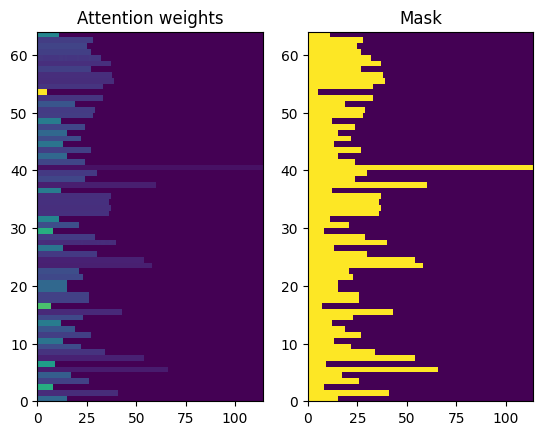

In [19]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [20]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [21]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
#   shape_checker = ShapeChecker()
#   shape_checker(x, 'batch t')
#   shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
#   shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
#   shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
#   shape_checker(x, 'batch t units')
#   shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
#   shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [22]:
decoder = Decoder(target_text_processor, UNITS)

In [23]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 114, 256)
input target tokens shape: (batch, t) (64, 113)
logits shape shape: (batch, target_vocabulary_size) (64, 113, 5000)


In [24]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [25]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [26]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [27]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'institution entitled started changing missed protected elections natura warning continuation',
       b'right go method door cannot necessary surprised formally training causing',
       b'according figures concur replaced organisms vallelersundi laws granted harbour fat'],
      dtype=object)

In [28]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [29]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

(64, 114, 256)
Context tokens, shape: (batch, s, units) (64, 114)
Target tokens, shape: (batch, t) (64, 113)
logits, shape: (batch, t, target_vocabulary_size) (64, 113, 5000)


In [30]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [31]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [32]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [33]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [34]:
model.evaluate(val_ds, steps=20, return_dict=True)

(None, None, 256)
(None, None, 256)
20/20 [==============================] - 24s 793ms/step - loss: 8.5168 - masked_acc: 2.4852e-04 - masked_loss: 8.5168


{'loss': 8.516790390014648,
 'masked_acc': 0.0002485222357790917,
 'masked_loss': 8.516790390014648}

In [35]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
(None, None, 256)
(None, None, 256)
100/100 [==============================] - 200s 2s/step - loss: 5.7780 - masked_acc: 0.1297 - masked_loss: 5.7780 - val_loss: 4.8910 - val_masked_acc: 0.2265 - val_masked_loss: 4.8910
Epoch 2/100
100/100 [==============================] - 184s 2s/step - loss: 4.6560 - masked_acc: 0.2450 - masked_loss: 4.6560 - val_loss: 4.4383 - val_masked_acc: 0.2621 - val_masked_loss: 4.4383
Epoch 3/100
100/100 [==============================] - 190s 2s/step - loss: 4.3527 - masked_acc: 0.2750 - masked_loss: 4.3527 - val_loss: 4.1936 - val_masked_acc: 0.2876 - val_masked_loss: 4.1936
Epoch 4/100
100/100 [==============================] - 182s 2s/step - loss: 3.9956 - masked_acc: 0.3070 - masked_loss: 3.9957 - val_loss: 4.0370 - val_masked_acc: 0.3037 - val_masked_loss: 4.0370
Epoch 5/100
100/100 [==============================] - 185s 2s/step - loss: 3.8610 - masked_acc: 0.3240 - masked_loss: 3.8610 - val_loss: 3.8680 - val_masked_acc: 0.3244 - val_mask

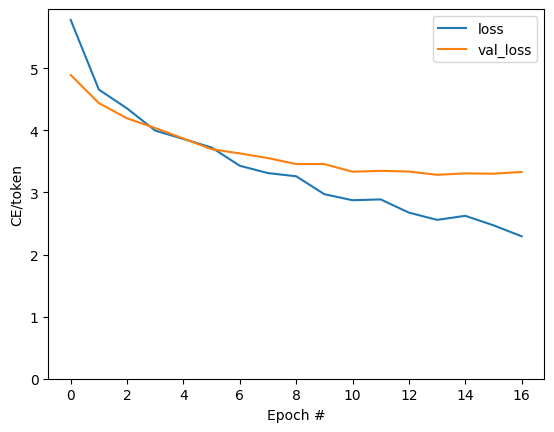

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

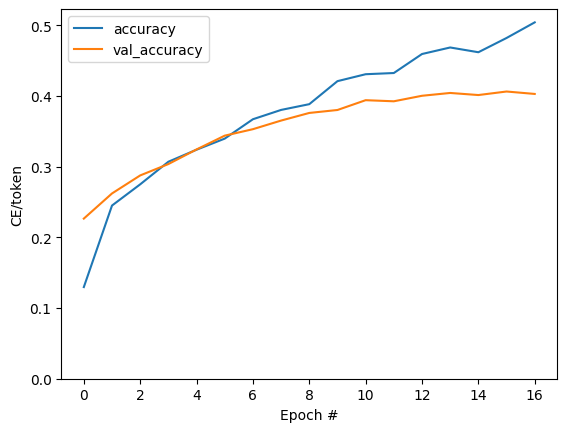

In [37]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [38]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [39]:
result = model.translate(['The commission has rejected the proposal']) 
result[0].numpy().decode()

(1, 8, 256)


'the european union [UNK] [UNK] [UNK] . '

In [40]:
from nltk.translate.bleu_score import sentence_bleu

for i in range(25001,25017): # evaluating 15 unseen sentences which were not a part of training data
    try:
        result = model.translate([europarl_lines_bp['German_Text'].values[i]]) 
        hypothesis = result[0].numpy().decode()
        print('Input Sentence', europarl_lines_bp['German_Text'].values[i])
        print('Predicted Sentence', hypothesis)
        print('Actual Sentence', europarl_lines_bp['English_Text'].values[i])
        hypothesis = str(hypothesis).split()
        reference = str(europarl_lines_bp['English_Text'].values[i]).split()
        #the maximum is bigram, so assign the weight into 2 half.
        BLEUscore = sentence_bleu([reference], hypothesis)
        print('BLEU Score:',BLEUscore, '\n')
    except:
        continue

(1, 42, 256)
Input Sentence Aus diesem Grund beobachten wir sehr aufmerksam alles, was eine Zuwiderhandlung gegen die Grundsätze darstellen könnte, die uns in diesem Bereich einen. Im Rahmen der Gemeinsamen Außen- und Sicherheitspolitik haben wir Verletzungen dieser Grundsätze stets angeprangert.
Predicted Sentence this is why we are very well aware of the principles of the principles of the principles , which we have to find ourselves in this area , which has always been a very important , in this area , which has always been achieved . 
Actual Sentence We are therefore alert to any risk of weakening the principles that unite us in this area, and we have always denounced any violations through our common foreign and security policy.
BLEU Score: 0.346966645494591 

(1, 31, 256)


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input Sentence In solchen Fällen versuchen wir, mit Hilfe des uns zu Gebote stehenden Instrumentariums Druck auszuüben, der sowohl zeitlich als auch in seinen Folgen wirkungsvoll sein kann.
Predicted Sentence in such cases , we are trying to provide with the assistance to the partners , which is to be welcomed and also to create a [UNK] relationship between both parties and both sides . 
Actual Sentence In such cases we seek to use the instruments available to us to exert pressure in a timely and effective way.
BLEU Score: 0.30277029197532096 

(1, 30, 256)
Input Sentence Häufig haben wir - und dessen sind wir uns bewußt - das Gewünschte nicht erreicht. Wir sind jedoch fest entschlossen, auch künftig mit der gleichen Entschiedenheit vorzugehen.
Predicted Sentence we have not heard that we are aware of the fact that we are not able to achieve a genuine [UNK] in the same . 
Actual Sentence We are aware that in many cases we have not achieved everything we might wish, but we firmly intend

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input Sentence Herr Präsident! Ungeachtet der Schwere und der Häufigkeit der Verletzung der Menschenrechte, die die Genfer Abkommen und ihre Protokolle zu schützen suchen, bin ich der Meinung, daß das neue Jahrtausend sehr wohl einige Elemente der Hoffnung in sich birgt.
Predicted Sentence mr president , regardless of the serious problems of the [UNK] of human rights and the [UNK] of the geneva convention , and i am thinking of the geneva convention , and i am thinking of the fact that the geneva convention is also [UNK] and for the fact that
Actual Sentence Mr President, despite the gravity and the frequency of human rights violations that the Geneva Conventions and their protocols attempt to prevent, I do believe that the new millennium gives us some cause for hope.
BLEU Score: 0.14213743662752684 

(1, 34, 256)
Input Sentence Diese Hoffnung basiert im wesentlichen auf der fortschreitenden Stabilisierung einer internationalen Werteordnung, die sich schon jetzt nicht mehr hinter überh

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input Sentence Wenn auch langsam, so schreiten wir heute ohne den geringsten Zweifel auf dem Weg dieser neuen, internationalen Werteordnung voran. Gefördert wird diese Entwicklung durch die Globalisierung der Information, die helfen wird, diese Werteordnung im kollektiven Bewußtsein unserer Gesellschaften zu verankern.
Predicted Sentence if so , we are [UNK] , once again , we are discussing the fact that the new [UNK] , [UNK] [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] , [UNK] our society . 
Actual Sentence Although it is a slow process, there can be no doubt that we are already on the way to establishing this new international set of values and that the process of information globalisation is assisting in this and helping it to take root in our societies' collective consciousness.
BLEU Score: 0.2777619034011791 

(1, 44, 256)
Input Sentence Dieses Vorgehen muß von unseren Bürgern in dem Sinne verinnerlicht werden, daß sich ein Automati